In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress tracking

def enhance_contrast(image, clip_limit=2.0):
    """Enhance contrast of an image using CLAHE with a customizable clipLimit."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    return clahe.apply(image)

def extract_sift_keypoints(image):
    """Detect SIFT keypoints in an image."""
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(image, None)
    return len(keypoints)

def load_balanced_images_with_dynamic_contrast(base_path, image_size=(62, 64), max_per_class=1000, keypoint_threshold=5, max_iterations=5):
    """
    Load a balanced subset of images and iteratively enhance contrast until keypoints reach threshold.
    
    Args:
        base_path (str): Root directory containing label subfolders (e.g., 0, 1, 2...).
        image_size (tuple): Target size for resizing images.
        max_per_class (int): Maximum number of images to load per class.
        keypoint_threshold (int): Minimum keypoints; enhance contrast until keypoints reach this value.
        max_iterations (int): Maximum number of contrast enhancement iterations.
        
    Returns:
        np.array: List of processed image arrays.
        np.array: Corresponding labels for the images.
    """
    images = []
    labels = []
    enhanced_indices = []  # Track which images were enhanced

    for label in range(6):  # Labels are 0 to 5
        folder_path = os.path.join(base_path, str(label))
        all_files = os.listdir(folder_path)

        # Randomly shuffle files to avoid bias
        np.random.shuffle(all_files)

        # Limit to the desired number of images per class
        for file_name in tqdm(all_files[:max_per_class], desc=f"Loading Class {label}"):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, image_size)

                # Initial keypoint detection
                keypoint_count = extract_sift_keypoints(img_resized)
                iterations = 0
                
                # Keep enhancing the contrast until keypoints reach the threshold or max iterations are reached
                while keypoint_count < keypoint_threshold and iterations < max_iterations:
                    img_resized = enhance_contrast(img_resized, clip_limit=2.0 + 1.0 * iterations)  # Gradually increase clipLimit
                    keypoint_count = extract_sift_keypoints(img_resized)
                    iterations += 1
                
                if iterations > 0:
                    enhanced_indices.append((label, file_name))  # Track enhanced images

                images.append(img_resized)
                labels.append(label)
    
    print(f"Enhanced contrast for {len(enhanced_indices)} images with low keypoints.")
    return np.array(images), np.array(labels)

# Example Usage
base_path = r"C:\Users\jeremy.hicks\Desktop\School\2024\CSC 546 Advanced AI\Hep-Cells\Organized"
max_per_class = 1500  # Adjust based on dataset
images, labels = load_balanced_images_with_dynamic_contrast(base_path, max_per_class=max_per_class)

print(f"Loaded {len(images)} images with {len(np.unique(labels))} labels.")


Loading Class 5: 100%|████████████████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 235.29it/s]

Enhanced contrast for 7161 images with low keypoints.
Loaded 9000 images with 6 labels.


In [2]:
from tqdm import tqdm

def preprocess_images_with_progress(images):
    """
    Extract SIFT features for a batch of images with a progress bar.
    
    Args:
        images (np.array): Array of preprocessed images.
        
    Returns:
        sift_descriptors (np.array): Combined SIFT descriptors from all images.
        image_descriptor_indices (list): List of indices mapping images to their descriptors.
    """
    sift_descriptors = []
    image_descriptor_indices = []  # To map which descriptors belong to which image
    #sift = cv2.SIFT_create()
    sift = cv2.SIFT_create(nfeatures=5000)
    
    for idx, image in enumerate(tqdm(images, desc="Extracting SIFT features")):
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            sift_descriptors.extend(descriptors)
            image_descriptor_indices.extend([idx] * len(descriptors))  # Map descriptors to image index
    
    return np.array(sift_descriptors), image_descriptor_indices

# Example Usage
sift_features, descriptor_indices = preprocess_images_with_progress(images)

print(f"Total SIFT descriptors extracted: {sift_features.shape}")
print(f"Descriptor mapping to images: {len(descriptor_indices)} descriptors mapped.")

Extracting SIFT features: 100%|███████████████████████████████████████████████████| 9000/9000 [00:14<00:00, 616.41it/s]


Total SIFT descriptors extracted: (197278, 128)
Descriptor mapping to images: 197278 descriptors mapped.


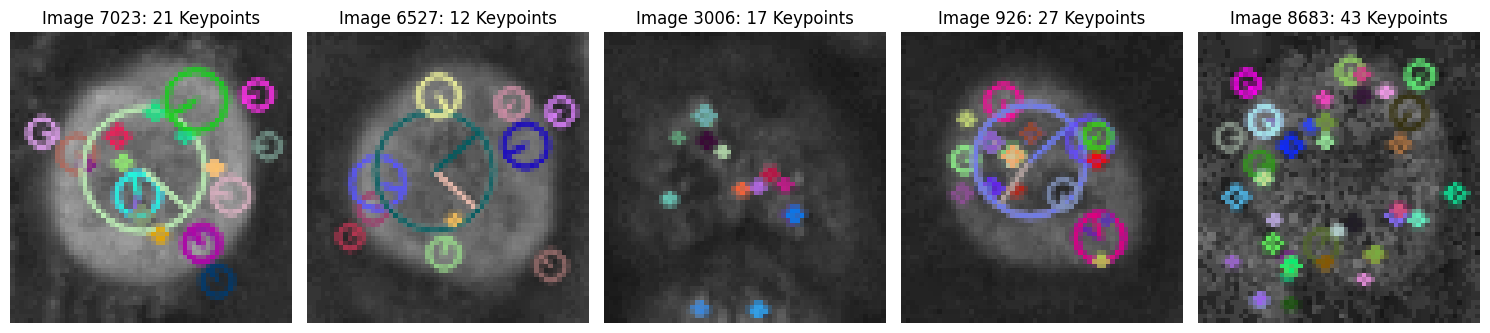

In [3]:
import matplotlib.pyplot as plt

def visualize_sift_keypoints(images, num_samples=5):
    """
    Visualize SIFT keypoints for a random sample of images.
    
    Args:
        images (np.array): Array of preloaded grayscale images.
        num_samples (int): Number of images to visualize.
    """
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        img = images[idx]
        sift = cv2.SIFT_create()
        keypoints, _ = sift.detectAndCompute(img, None)
        img_with_keypoints = cv2.drawKeypoints(
            img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_with_keypoints, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {idx}: {len(keypoints)} Keypoints")
    
    plt.tight_layout()
    plt.show()

# Example Usage
visualize_sift_keypoints(images, num_samples=5)


In [4]:
from sklearn.cluster import MiniBatchKMeans
import joblib  # For saving the model
from tqdm import tqdm

def cluster_sift_descriptors_with_progress(sift_features, num_clusters=500, batch_size=1000, max_iter=300):
    """
    Cluster SIFT descriptors using MiniBatchKMeans with a progress bar for iterations.
    
    Args:
        sift_features (np.array): Array of SIFT descriptors.
        num_clusters (int): Number of clusters (visual words).
        batch_size (int): Batch size for MiniBatchKMeans.
        max_iter (int): Maximum number of iterations for MiniBatchKMeans.
        
    Returns:
        kmeans (MiniBatchKMeans): Trained MiniBatchKMeans model.
    """
    print("Clustering descriptors with MiniBatchKMeans...")
    progress_bar = tqdm(total=max_iter, desc="Clustering Iterations", position=0, leave=True)

    # Initialize MiniBatchKMeans
    kmeans = MiniBatchKMeans(
        n_clusters=num_clusters,
        random_state=42,
        batch_size=batch_size,
        max_iter=max_iter
    )

    # Fit MiniBatchKMeans with a progress bar
    for _ in range(max_iter):
        kmeans.partial_fit(sift_features)  # Incremental fitting
        progress_bar.update(1)

    progress_bar.close()
    return kmeans

# Example Usage
num_clusters = 500  # Number of visual words
sift_features_float64 = sift_features.astype(np.float64)

# Cluster descriptors with a progress bar
kmeans_model = cluster_sift_descriptors_with_progress(sift_features_float64, num_clusters=num_clusters)

# Save the trained KMeans model for later use
joblib.dump(kmeans_model, "kmeans_visual_words.pkl")
print(f"KMeans clustering completed. {num_clusters} visual words created.")


Clustering descriptors with MiniBatchKMeans...


Clustering Iterations:   0%|                                                                   | 0/300 [00:00<?, ?it/s]C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
Clustering Iterations: 100%|█████████████████████████████████████████████████████████| 300/300 [02:59<00:00,  1.67it/s]

KMeans clustering completed. 500 visual words created.


Assigning Descriptors to Clusters: 100%|█████████████████████████████████████████| 9000/9000 [00:02<00:00, 4025.07it/s]


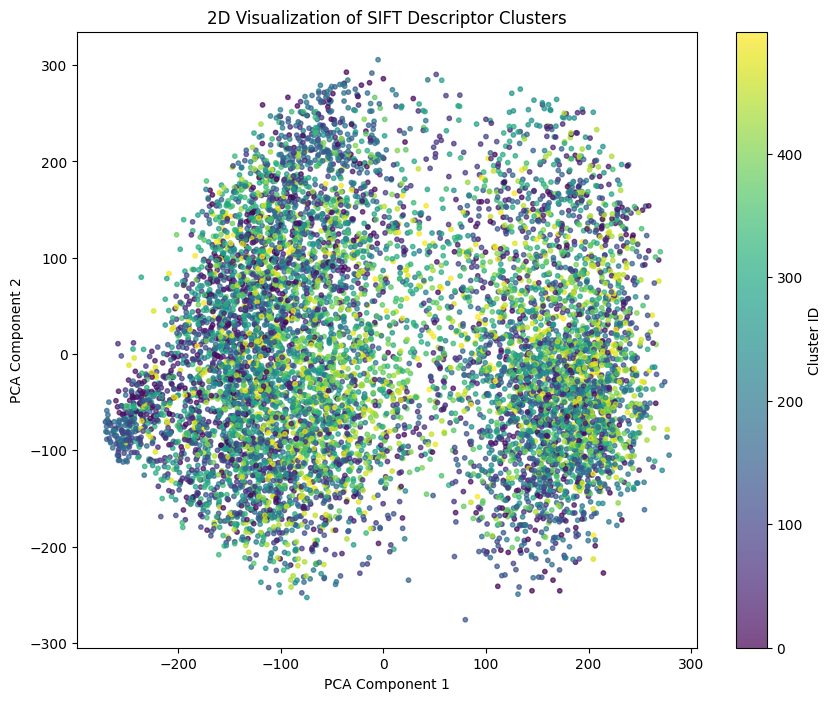

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

def visualize_sift_clusters(sift_features, kmeans_model, num_samples=1500*6):
    """
    Visualize SIFT descriptor clusters in 2D space using PCA, with a progress bar.
    
    Args:
        sift_features (np.array): SIFT descriptors.
        kmeans_model (KMeans): Trained KMeans model.
        num_samples (int): Number of descriptors to sample for visualization.
    """
    # Sample a subset of descriptors for visualization
    sampled_indices = np.random.choice(len(sift_features_float64), num_samples, replace=False)
    sampled_features = sift_features[sampled_indices]
    
    # Ensure descriptors are of the correct type for KMeans prediction
    sampled_features = sampled_features.astype(np.float64)  # Convert to float64
    
    # Predict cluster labels for sampled descriptors with a progress bar
    sampled_labels = []
    for i in tqdm(range(len(sampled_features)), desc="Assigning Descriptors to Clusters"):
        # Ensure input to predict() is 2D (shape: (1, n_features))
        sampled_labels.append(kmeans_model.predict([sampled_features[i]])[0])
    sampled_labels = np.array(sampled_labels)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(sampled_features)
    
    # Plot the clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=sampled_labels, cmap='viridis', s=10, alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title("2D Visualization of SIFT Descriptor Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Example Usage
visualize_sift_clusters(sift_features_float64, kmeans_model)

In [6]:
print(f"sift_features dtype: {sift_features_float64.dtype}")
print(f"kmeans_model.cluster_centers_ dtype: {kmeans_model.cluster_centers_.dtype}")
#print(f"sampled_features dtype: {kmeans_model.dtype}")

sift_features dtype: float64
kmeans_model.cluster_centers_ dtype: float64


In [7]:
def extract_sift_features(image):
    """
    Extract SIFT descriptors from an image.

    Args:
        image (numpy array): Input grayscale image.

    Returns:
        descriptors (numpy array or None): SIFT descriptors for the image,
                                           or None if no keypoints are found.
    """
    sift = cv2.SIFT_create()  # Initialize SIFT
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors


#import numpy as np
from scipy.spatial.distance import cdist

def generate_bovw_histograms(images, kmeans_model):
    """
    Generate Bag of Visual Words (BoVW) histograms for a set of images.
    
    Args:
        images (np.array): Array of preloaded images.
        kmeans_model (KMeans): Trained KMeans model.
        
    Returns:
        histograms (np.array): Array of BoVW histograms for each image.
    """
    num_clusters = kmeans_model.n_clusters
    histograms = []
    
    for image in tqdm(images, desc="Generating BoVW histograms"):
        descriptors = extract_sift_features(image)
        #print(f"descriptors: {descriptors.dtype}")
        if descriptors is not None:
            # Assign each descriptor to the nearest cluster center
            cluster_assignments = kmeans_model.predict(descriptors.astype(np.float64))
            # Create a histogram of visual words
            histogram, _ = np.histogram(cluster_assignments, bins=num_clusters, range=(0, num_clusters))
        else:
            # If no descriptors, use an empty histogram
            histogram = np.zeros(num_clusters)
        
        # Normalize the histogram
        histogram = histogram / np.sum(histogram) if np.sum(histogram) > 0 else histogram
        histograms.append(histogram)
    
    return np.array(histograms)

# Example Usage
bovw_histograms = generate_bovw_histograms(images, kmeans_model)
print(f"Generated BoVW histograms with shape: {bovw_histograms.shape}")

Generating BoVW histograms: 100%|█████████████████████████████████████████████████| 9000/9000 [00:19<00:00, 458.39it/s]


Generated BoVW histograms with shape: (9000, 500)


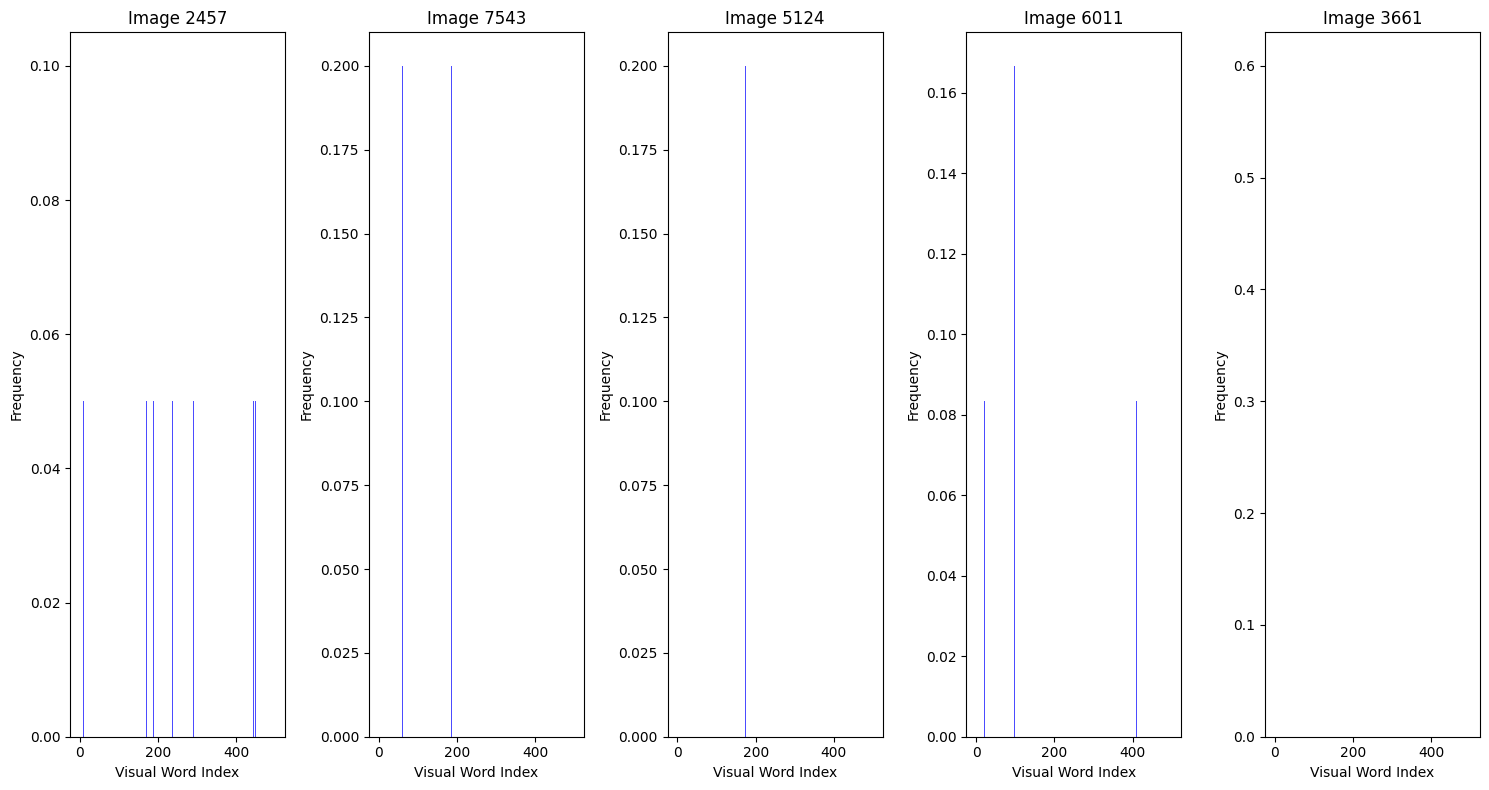

In [8]:
def visualize_bovw_histograms(bovw_histograms, num_samples=5):
    """
    Visualize Bag of Visual Words (BoVW) histograms for a sample of images.
    
    Args:
        bovw_histograms (np.array): Array of BoVW histograms.
        num_samples (int): Number of histograms to visualize.
    """
    sample_indices = np.random.choice(len(bovw_histograms), num_samples, replace=False)
    plt.figure(figsize=(15, 8))
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.bar(range(len(bovw_histograms[idx])), bovw_histograms[idx], color='blue', alpha=0.7)
        plt.title(f"Image {idx}")
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.tight_layout()
    
    plt.show()

# Example Usage
visualize_bovw_histograms(bovw_histograms, num_samples=5)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming `bovw_histograms` contains the feature vectors for your images
# and `labels` contains the corresponding labels for each image

# Split the data into training and testing sets
og_X_train, og_X_test, og_y_train, og_y_test = train_test_split(
    bovw_histograms, labels, test_size=0.3, random_state=42, stratify=labels
)

# Standardize the data (important for SVM, KNN, etc.)
scaler = StandardScaler()
og_X_train_scaled = scaler.fit_transform(og_X_train)
og_X_test_scaled = scaler.transform(og_X_test)

print(f"Training set size: {og_X_train_scaled.shape[0]}, Test set size: {og_X_test_scaled.shape[0]}")


Training set size: 6300, Test set size: 2700


Class Distribution: Counter({3: 1050, 1: 1050, 5: 1050, 2: 1050, 0: 1050, 4: 1050})


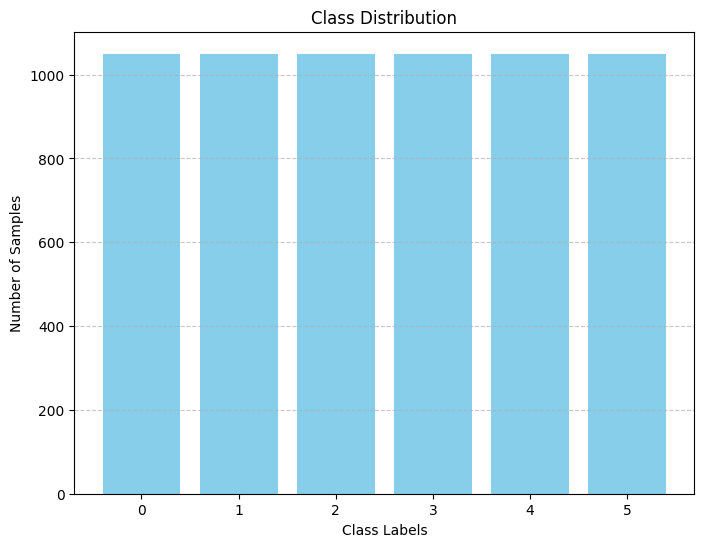

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `y_train` contains the labels for your training set
def plot_class_distribution(labels):
    """
    Plot class distribution to check for balance.
    """
    class_counts = Counter(labels)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    # Print class distribution
    print("Class Distribution:", class_counts)

    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example: Visualize training set labels
plot_class_distribution(og_y_train)


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time

# Train an SVM model with progress bar
def train_svm_with_progress(og_X_train_scaled, og_y_train):
    
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(og_X_train_scaled, og_y_train)
    
    return svm_model

# Train the SVM with progress
svm_model = train_svm_with_progress(og_X_train_scaled, og_y_train)

# Predict on the test set
svm_y_pred = svm_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, svm_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.44      0.38       450
           1       0.38      0.38      0.38       450
           2       0.38      0.41      0.39       450
           3       0.38      0.35      0.37       450
           4       0.38      0.31      0.34       450
           5       0.59      0.50      0.54       450

    accuracy                           0.40      2700
   macro avg       0.41      0.40      0.40      2700
weighted avg       0.41      0.40      0.40      2700



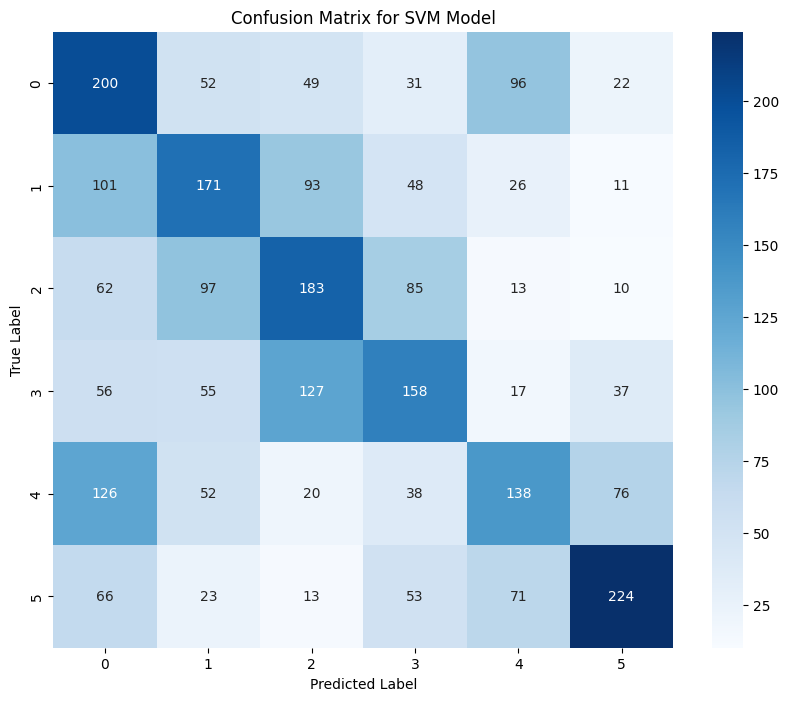

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(og_y_test, svm_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Performing cross-validation for KNN...


Evaluating KNN for different k: 100%|██████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]


Optimal k: 14
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.32      0.30       467
           1       0.46      0.17      0.25       446
           2       0.44      0.29      0.35       443
           3       0.47      0.37      0.41       439
           4       0.24      0.55      0.33       461
           5       0.75      0.45      0.57       444

    accuracy                           0.36      2700
   macro avg       0.44      0.36      0.37      2700
weighted avg       0.43      0.36      0.37      2700



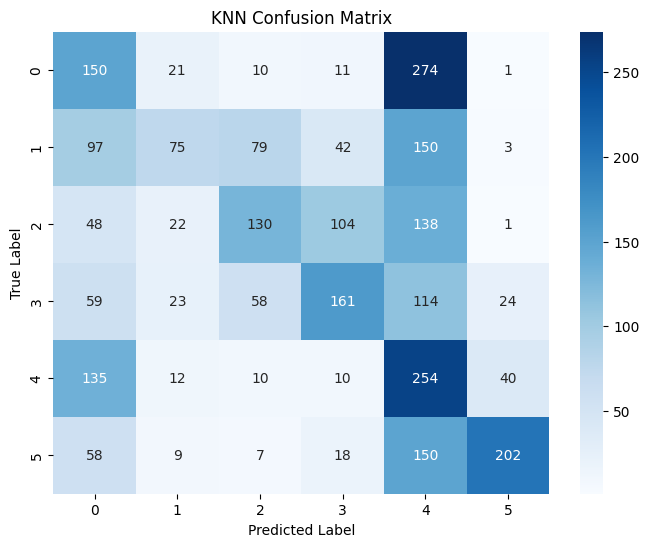

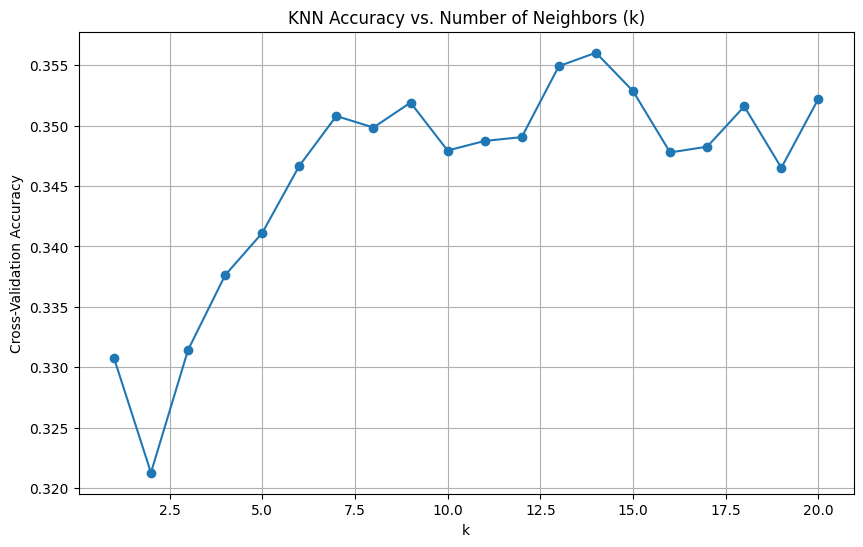

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Split data (if not already split)
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(bovw_histograms, labels, test_size=0.3, random_state=42)

# Try different values of k
k_values = range(1, 21)
cv_scores = []

print("Performing cross-validation for KNN...")
for k in tqdm(k_values, desc="Evaluating KNN for different k"):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, knn_X_train, knn_y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Select the best k
optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}")

# Train final KNN model with the optimal k
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(knn_X_train, knn_y_train)

# Predict and evaluate
knn_y_pred = knn_final.predict(knn_X_test)
print("Classification Report:\n", classification_report(knn_y_test, knn_y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(knn_y_test, knn_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("k")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.48      0.44       450
           1       0.55      0.36      0.43       450
           2       0.48      0.54      0.51       450
           3       0.51      0.45      0.48       450
           4       0.44      0.44      0.44       450
           5       0.62      0.70      0.66       450

    accuracy                           0.50      2700
   macro avg       0.50      0.50      0.49      2700
weighted avg       0.50      0.50      0.49      2700



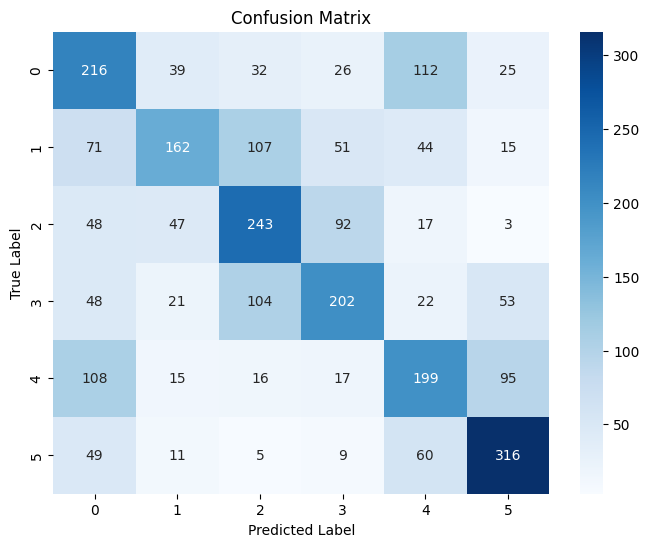

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Train a Random Forest model with progress bar
def train_random_forest_with_progress(og_X_train_scaled, og_y_train, n_estimators=100):
    """
    Train a Random Forest classifier.
    
    Args:
        X_train_scaled (np.array): Scaled training features.
        y_train (np.array): Training labels.
        n_estimators (int): Number of trees in the forest.
    
    Returns:
        model: Trained Random Forest model.
    """
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Fit the actual Random Forest model
    rf_model.fit(og_X_train_scaled, og_y_train)
    return rf_model

# Train the Random Forest with progress
rf_model = train_random_forest_with_progress(og_X_train_scaled, og_y_train, n_estimators=100)

# Predict on the test set
rf_y_pred = rf_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, rf_y_pred))

# Plot the confusion matrix
def plot_confusion_matrix(og_y_test, rf_y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(og_y_test, rf_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(og_y_test), yticklabels=np.unique(og_y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(og_y_test, rf_y_pred)


Training XGBoost model...


C:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.47      0.44       450
           1       0.46      0.38      0.41       450
           2       0.45      0.47      0.46       450
           3       0.46      0.46      0.46       450
           4       0.46      0.48      0.47       450
           5       0.68      0.68      0.68       450

    accuracy                           0.49      2700
   macro avg       0.49      0.49      0.49      2700
weighted avg       0.49      0.49      0.49      2700



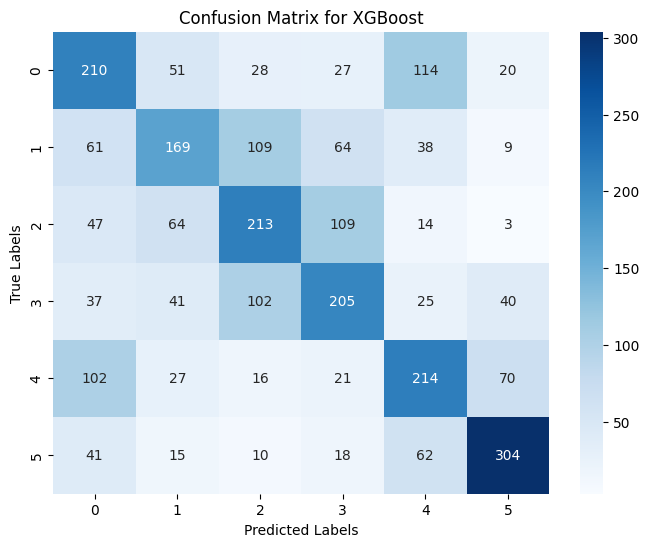

In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def train_xgboost(og_X_train_scaled, og_y_train):
    """Train XGBoost model."""
    print("Training XGBoost model...")
    
    # Create the XGBoost classifier
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=6,  # Assuming 6 classes (0-5)
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    model.fit(og_X_train_scaled, og_y_train)
    return model

# Example Usage
xgb_model = train_xgboost(og_X_train_scaled, og_y_train)

# Predict on the test set
xgb_y_pred = xgb_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, xgb_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(og_y_test, xgb_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(og_y_test), yticklabels=np.unique(og_y_test))
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Decision Tree Accuracy: 0.3572
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.27      0.28       300
           1       0.33      0.34      0.34       300
           2       0.34      0.35      0.35       300
           3       0.34      0.36      0.35       300
           4       0.34      0.33      0.33       300
           5       0.54      0.48      0.50       300

    accuracy                           0.36      1800
   macro avg       0.36      0.36      0.36      1800
weighted avg       0.36      0.36      0.36      1800



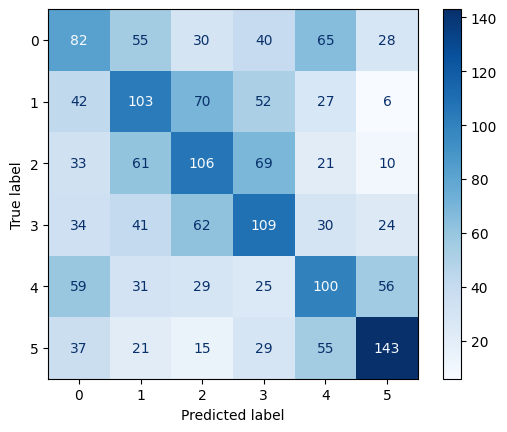

In [16]:
#print(X_train_scaled.shape)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Assuming BoVW histograms are ready as `bovw_histograms` and labels as `labels`
# Split the data into train and test sets
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(bovw_histograms, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize and train the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(dt_X_train, dt_y_train)

# Make predictions
dt_y_pred = decision_tree.predict(dt_X_test)

# Evaluate the model
accuracy = accuracy_score(dt_y_test, dt_y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(dt_y_test, dt_y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(dt_y_test, dt_y_pred, display_labels=[0, 1, 2, 3, 4, 5], cmap="Blues")

In [17]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_from_folders(base_path, image_size=(62, 64), num_images_per_class=1000):
    """
    Load images and labels from a directory structure, ensuring a balanced dataset with a limited number of images per class.
    
    Args:
        base_path (str): Root directory containing label subfolders (e.g., 0, 1, 2...).
        image_size (tuple): Target size for resizing images.
        num_images_per_class (int): Maximum number of images to load per class.
        
    Returns:
        images (np.array): Array of preprocessed image arrays.
        labels (np.array): Array of corresponding labels for the images.
    """
    images = []
    labels = []

    for label in range(6):  # labels are 0 to 5
        folder_path = os.path.join(base_path, str(label))
        class_images = []  # Store all images from the current class
        
        # Collect all images for the current class
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, image_size)  # Resize to 62x64
                class_images.append(img_resized)
        
        # Limit the number of images for each class (randomly select up to `num_images_per_class` images)
        class_images = np.array(class_images)  # Convert to numpy array
        if len(class_images) > num_images_per_class:
            # Randomly select num_images_per_class images
            indices = np.random.choice(len(class_images), num_images_per_class, replace=False)
            class_images = class_images[indices]
        
        # Append the selected images and labels to the final dataset
        images.extend(class_images)
        labels.extend([label] * len(class_images))

    return np.array(images), np.array(labels)

# Example Usage
base_path = r"C:\Users\jeremy.hicks\Desktop\School\2024\CSC 546 Advanced AI\Hep-Cells\Organized"
num_images_per_class = 1500  # Limit the number of images per class
images, labels = load_images_from_folders(base_path, num_images_per_class=num_images_per_class)
print(f"Loaded {len(images)} images with {len(np.unique(labels))} labels.")

# Normalize the images
images = images.astype('float32') / 255.0  # Normalize pixel values

# Reshape for CNN
refr_X_reshaped = images.reshape(-1, 62, 64, 1)  # Shape for CNN input
print(f"Reshaped images: {refr_X_reshaped.shape}")

# Split the data into training and testing sets
refr_X_train, refr_X_test, refr_y_train, refr_y_test = train_test_split(refr_X_reshaped, labels, test_size=0.5, random_state=42)

# Verify the split
print(f"Training data: {refr_X_train.shape}, Testing data: {refr_X_test.shape}")
print(f"Initial X_train shape: {refr_X_train.shape}")
print(f"Initial y_train shape: {refr_y_train.shape}")
print(f"Initial X_test shape: {refr_X_test.shape}")
print(f"Initial y_test shape: {refr_y_test.shape}")
#print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
#print(f"y_train_one_hot shape: {y_train_one_hot.shape}")

Loaded 9000 images with 6 labels.
Reshaped images: (9000, 62, 64, 1)
Training data: (4500, 62, 64, 1), Testing data: (4500, 62, 64, 1)
Initial X_train shape: (4500, 62, 64, 1)
Initial y_train shape: (4500,)
Initial X_test shape: (4500, 62, 64, 1)
Initial y_test shape: (4500,)


In [18]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding of labels
y_train_one_hot = to_categorical(refr_y_train, num_classes=6)
y_test_one_hot = to_categorical(refr_y_test, num_classes=6)

# Check the shapes of the one-hot encoded labels
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")


y_train_one_hot shape: (4500, 6)
y_test_one_hot shape: (4500, 6)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Prepare the data
#X_train_reshaped = images.reshape(-1, 62, 64, 1)  # Shape for CNN input: (num_samples, height, width, 1)
#X_test_reshaped = X_test.reshape(-1, 62, 64, 1)  # Assuming X_test is loaded and processed similarly

# Convert labels to one-hot encoding
#y_train_one_hot = to_categorical(y_train, num_classes=6)
#y_test_one_hot = to_categorical(y_test, num_classes=6)

# Normalize images to [0, 1] range (if not already done)
#X_train_reshaped = X_train_reshaped.astype('float32') / 255.0
#X_test_reshaped = X_test_reshaped.astype('float32') / 255.0

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(62, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(refr_X_train, y_train_one_hot, epochs=54, batch_size=32, validation_data=(refr_X_test, y_test_one_hot))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(refr_X_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and classification report
cnn_y_pred = cnn_model.predict(refr_X_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)  # Convert predictions to class labels

# Evaluate performance with classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(refr_y_test, cnn_y_pred_classes))

Epoch 1/54


C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2526 - loss: 1.6774 - val_accuracy: 0.4269 - val_loss: 1.3963
Epoch 2/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4188 - loss: 1.3731 - val_accuracy: 0.4609 - val_loss: 1.2799
Epoch 3/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4570 - loss: 1.2937 - val_accuracy: 0.4949 - val_loss: 1.2113
Epoch 4/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4817 - loss: 1.2483 - val_accuracy: 0.5196 - val_loss: 1.1720
Epoch 5/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5271 - loss: 1.1829 - val_accuracy: 0.5280 - val_loss: 1.1365
Epoch 6/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5276 - loss: 1.1529 - val_accuracy: 0.5544 - val_loss: 1.1283
Epoch 7/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5458 - loss: 1.1333 - val_accuracy: 0.5542 - val_loss: 1.1003
Epoch 8/54
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5463 - loss: 1.1132 - val_accuracy: 0.568

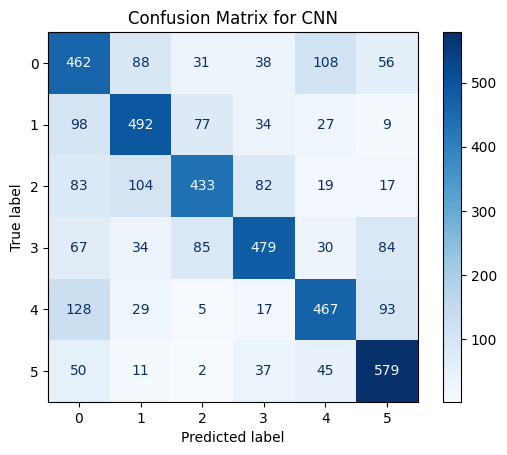

In [20]:
# Import required modules for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(refr_y_test, cnn_y_pred_classes, labels=range(6))  # Replace 6 with the number of classes if different

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(6))  # Replace range(6) with class names if needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CNN")
plt.show()
